In [46]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numpy.random as npr
import logistic_svd.numba_version
logistic_svd.numba_version.simpletqdm.tqdm_type='notebook'

import matplotlib.pylab as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1d factor model

In [47]:
# generate some simulated data
Nc=5000
Ng=40
Nk=1
z=npr.randn(Nc,Nk)
alpha=npr.randn(Ng,Nk)
data = npr.rand(Nc,Ng) < (1 / (1+np.exp(-z@alpha.T)))

# fit model to simulated data
z_guess,alpha_guess,likelihoods=logistic_svd.numba_version.train(Nk,10,binary_matrix=data,approx=True)

# for comparison with the truth,
# use the true parameters to
# flip our estimates to the right sign
# (this orientation is not identifiable)
if np.sum(alpha_guess*alpha)<0:
    alpha_guess=-alpha_guess
    z_guess=-z_guess

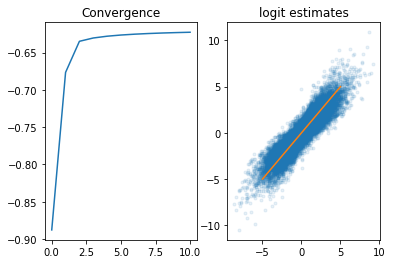

In [48]:
plt.subplot(1,2,1)
plt.plot(likelihoods)
plt.title("Convergence")


plt.subplot(1,2,2)
plt.plot((z_guess@alpha_guess.T).ravel(),(z@alpha.T).ravel(),'.',alpha=.1)
plt.title("logit estimates")
plt.plot([-5,5],[-5,5])


# bigger model

In [49]:
# simulated data
Nc=100
Ng=400
Nk=10
z=npr.randn(Nc,Nk)
alpha=npr.randn(Ng,Nk)
data = npr.rand(Nc,Ng) < (1 / (1+np.exp(-z@alpha.T)))

# fit model to data
z_guess,alpha_guess,likelihoods=logistic_svd.numba_version.train(Nk,10,binary_matrix=data)

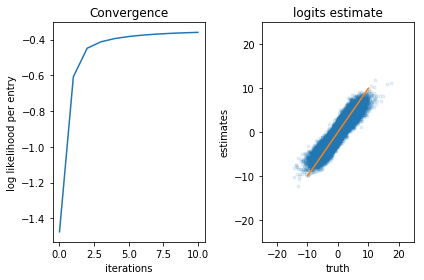

In [50]:
plt.subplot(1,2,1)
plt.plot(likelihoods)
plt.title("Convergence")
plt.xlabel("iterations")
plt.ylabel("log likelihood per entry")

plt.subplot(1,2,2)
plt.plot((z@alpha.T).ravel(),(z_guess@alpha_guess.T).ravel(),'.',alpha=.1)
plt.ylabel('estimates')
plt.xlabel("truth")
plt.plot([-10,10],[-10,10])
plt.title("logits estimate")
plt.xlim(-25,25)
plt.ylim(-25,25)

plt.tight_layout()

# sometimes it doesn't work, penalization can help a little

If ther are many more genes than cells, we will 

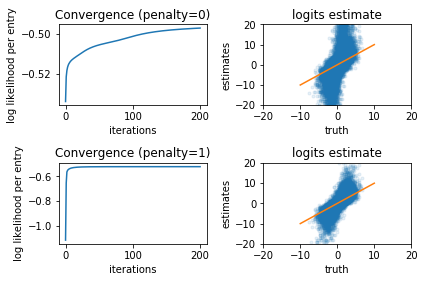

In [65]:
# simulated data
Nc=20
Ng=4000
Nk=2
z=npr.randn(Nc,Nk)
alpha=npr.randn(Ng,Nk)

# z[:,0]=1
# alpha[:,0]=npr.randn(Ng)-3

data = npr.rand(Nc,Ng) < (1 / (1+np.exp(-z@alpha.T)))


# fit model to data
for penalty in [0,1]:
    z_guess,alpha_guess,likelihoods=logistic_svd.numba_version.train(Nk,200,binary_matrix=data,penalty=penalty)

    plt.subplot(2,2,1+penalty*2)
    plt.plot(likelihoods)
    plt.title("Convergence (penalty=%d)"%penalty)
    plt.xlabel("iterations")
    plt.ylabel("log likelihood per entry")

    plt.subplot(2,2,2+penalty*2)
    plt.plot((z@alpha.T).ravel(),(z_guess@alpha_guess.T).ravel(),'.',alpha=.1)
    plt.ylabel('estimates')
    plt.xlabel("truth")
    plt.title("logits estimate")
    
    
    plt.plot([-10,10],[-10,10])
    plt.xlim(-20,20); plt.ylim(-20,20)
#     plt.plot([-10,2],[-10,2])
#     plt.xlim(-15,10)
#     plt.ylim(-15,10)

    plt.tight_layout()

# using lower-level functions

In [52]:
# simulated data
Nc=1000
Ng=4000
Nk=10
z=npr.randn(Nc,Nk)
alpha=npr.randn(Ng,Nk)
data = npr.rand(Nc,Ng)< (1 / (1+np.exp(-z@alpha.T)))
dmhalf=data-.5

In [56]:
# SVD for initial conditions
import scipy.sparse.linalg
U,e,V = scipy.sparse.linalg.svds(dmhalf,Nk)

z_guess=U@np.diag(e)
alpha_guess=V.T
logits=z@alpha.T
alpha_guess2=logistic_svd.numba_version.update_alpha(dmhalf,z_guess,alpha_guess,0,0)

print("likelihood under true model\t\t",logistic_svd.numba_version.likelihood(dmhalf,z,alpha,0))
print("initial likelihood\t\t\t",logistic_svd.numba_version.likelihood(dmhalf,z_guess,alpha_guess,0))

alpha_guess2=logistic_svd.numba_version.update_alpha(dmhalf,z_guess,alpha_guess,0,0)
print("likelihood after updating alpha\t\t",logistic_svd.numba_version.likelihood(dmhalf,z_guess,alpha_guess2,0))

z_guess2=logistic_svd.numba_version.update_z(dmhalf,z_guess,alpha_guess2,0,0)
print("likelihood after updating alpha and z\t",logistic_svd.numba_version.likelihood(dmhalf,z_guess2,alpha_guess2,0))


likelihood under true model		 -0.36107449484304155
initial likelihood			 -0.586071273501397
likelihood after updating alpha		 -0.41011567712234315
likelihood after updating alpha and z	 -0.38065710748380494


# inspecting the minorization we use

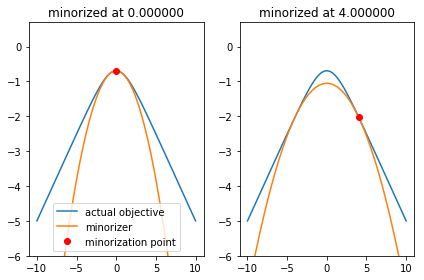

In [25]:
plt.subplot(1,2,1)
xs=np.r_[-10:10:100j]
plt.plot(xs,-np.log(2*np.cosh(xs/2)),label='actual objective')
x0=0
M,k=logistic_svd.numba_version.calc_minorizer(x0)
plt.plot(xs,k-.5*M*xs**2,label='minorizer')
plt.plot([x0],[-np.log(2*np.cosh(x0/2))],'ro',label='minorization point')
plt.legend()
plt.ylim(-6,np.log(2))

plt.title('minorized at %f'%x0)
    
    
plt.subplot(1,2,2)
plt.plot(xs,-np.log(2*np.cosh(xs/2)))
x0=4
M,k=logistic_svd.numba_version.calc_minorizer(x0)
plt.plot(xs,k-.5*M*xs**2)
plt.plot([x0],[-np.log(2*np.cosh(x0/2))],'ro')
plt.ylim(-6,np.log(2))

plt.title('minorized at %f'%x0)

plt.tight_layout()